In [2]:
import numpy as np
import pandas as pd
import os
import const
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import copy
from scipy import stats
from collections import defaultdict
from arguments import parse_arg, get_question, get_full_ordering

NUM_EXPERIMENTS = 48
NUM_MARKERS = 3

sns.set()

In [3]:
def get_event_counts(events, event_types):
    event_counts = {t: 0 for t in event_types}
    
    for event_type, events in events.items():
        event_counts[event_type] = len(events)
    
    event_types += ['total_nodes', 'total_arrows']
    
    event_counts['total_nodes'] = event_counts['node_create'] - event_counts['node_delete']
    event_counts['total_arrows'] = event_counts['arrow_create'] - event_counts['arrow_delete']
    
    return event_counts


def load_questionnaire_responses():
    df_quest = pd.read_csv(const.QUESTIONNAIRE_RESPONSES_FILE)
    
    df_quest['essay_freq_bin'] = pd.Series(['Uncommonly' if freq in ['Weeks', 'Days'] else 'Commonly' for freq in df_quest['essay_freq']])
    
    for cat_col in 'age gender subject role essay_freq essay_freq_bin preference'.split():
        df_quest[cat_col] = df_quest[cat_col].astype('category')
        
    df_quest['essay_freq'].cat.reorder_categories('Never Rarely Months Weeks Days'.split(), ordered=True, inplace=True)
    
    subjects = set()
    for subject_val in df_quest['subject']:
        subjects.update([s.strip() for s in subject_val.split(',')])
    
    for subject in subjects:
        df_quest[subject] = (df_quest['subject'].str.contains(subject))
    
    return df_quest, subjects

def load_scores():
    one_scores = {'graph': {}, 'plain': {}}
    all_scores = [copy.deepcopy(one_scores),
                  copy.deepcopy(one_scores),
                  copy.deepcopy(one_scores)]
    
    for marker_num in range(NUM_MARKERS):
        ordering, condition_ordering = get_full_ordering(marker_num)
        filename = os.path.join(const.SCORES_DATA_DIR, f'marker{marker_num+1}.csv')
        with open(filename, 'r') as f:
            for line in f.readlines():
                data = line.strip().replace('\n', '').split(',')
                index = int(data[0]) - 1  # -1 because csv files have 1-indexed column
                data = [int(d) for d in data[1:]]
                assert(len(data) == 5)
                
                experiment_id = ordering[index]
                all_scores[marker_num][condition_ordering[index]][experiment_id] = data
    
    return all_scores

def add_scores_columns(columns, row, condition, experiment_id, scores):
    new_cols = []
    for i, marker_scores in enumerate(scores):
        new_cols.extend([f'{t}_marker_{i+1}' for t in SCORE_TYPES])
        row.extend(marker_scores[condition][experiment_id])
    
    for score_i, score_type in enumerate(SCORE_TYPES):
        sum_score = sum(scores[m][condition][experiment_id][score_i] for m in range(NUM_MARKERS))
        new_cols.append(f'{score_type}_mean')
        row.append(sum_score / NUM_MARKERS)
        
    columns.extend(new_cols)
    return new_cols

def add_graph_category(columns, row, condition, experiment_id):
    columns.append('graph_category')
    if condition != "graph":
        row.append("NA")
        return
        
    with open(const.GRAPH_CATEGORISATION_FILE, 'r') as f:
        lines = f.readlines()
        # skip initial lines
        for i, line in enumerate(lines):
            if line.startswith('experiment_id'):
                data = lines[i+1:]
                break
        
        for line in data:
            cells = line.split(',')
            if str(experiment_id) == cells[0]:
                row.append(cells[1])
                return
    
    raise ValueError(f"not found for id {experiment_id}")

def make_df():
    rows = []
    
    # find all possible event types first
    event_types = set()
    for filename in os.listdir(const.DATA_DIR):
        with open(os.path.join(const.DATA_DIR, filename), 'r') as f:
            data = json.load(f)
            event_types.update(data['logs']['events'].keys())
    event_types = list(event_types)  # so it is ordered
    
    scores = load_scores()
    
    # generate all columns and rows
    for filename in os.listdir(const.DATA_DIR):
        columns = []
        row = []
        
        with open(os.path.join(const.DATA_DIR, filename), 'r') as f:
            data = json.load(f)
            for key, val in data['params'].items():
                if key == "duration":
                    continue
                    
                columns.append(key)
                row.append(val)
            
            arg = parse_arg(data['argument'])
            columns.append("arg_words")
            row.append(len(arg.split()))
            
            columns.append("arg_chars")
            row.append(len(arg))
            
            columns.append("arg")
            row.append(arg)
            
            columns.append("question")
            params = data['params']
            question = get_question(params['condition'], params['novelToolFirst'], params['sspaceFirst'])
            row.append(question)
            
            columns.append("order")
            is_first = question == ("sspace" if params['sspaceFirst'] else "biohacking")
            # sanity check
            assert(is_first == (params['condition'] == ('graph' if params['novelToolFirst'] else "plain")))
            row.append("First" if is_first else "Second")
            
            event_counts = get_event_counts(data['logs']['events'], event_types)
            columns.extend(event_counts.keys())
            row.extend(event_counts.values())
            
            scores_cols = add_scores_columns(columns, row, params['condition'],
                                          int(params['experimentId']), scores)
            
            add_graph_category(columns, row, params['condition'], params['experimentId'])
            
        rows.append(row)
    
    df = pd.DataFrame(np.array(rows), columns=columns)
    for num_col in 'arg_words arg_chars experimentId'.split() + list(event_types) + scores_cols:
        df[num_col] = pd.to_numeric(df[num_col])
    
    for cat_col in 'condition question order graph_category'.split():
        df[cat_col] = df[cat_col].astype('category')
    
    for bool_col in 'novelToolFirst sspaceFirst'.split():
        df[bool_col] = df[bool_col].map({'True': True, 'False': False})
        df[bool_col] = df[bool_col].astype('boolean')

    graph_categories_ordered_by_count = dict(df[df['condition'] == 'graph']['graph_category'].value_counts()).keys()    
    df['graph_category'].cat.reorder_categories(graph_categories_ordered_by_count, 
                                                ordered=True, inplace=True)

    return df

SCORE_TYPES = ['clarity', 'persuasiveness', 'structure', 'objection_resp', 'overall']

df = make_df()

df_quest, subjects = load_questionnaire_responses()

df = df.merge(df_quest, left_on="experimentId", right_on="id").drop("id", axis=1)

df_graph = df[df['condition'] == 'graph']
df_plain = df[df['condition'] == 'plain']

df_postgrad = df[df['role'] == 'Postgrad']
df_undergrad = df[df['role'] == 'Undergrad']

# df_participant = df.groupby('experimentId')

score_cols = [col for col in list(df) if any([t in col for t in SCORE_TYPES])]
df_scores = df[score_cols]

In [4]:
def run_ttest(df_a, df_b, col, should_print=True, decimal_places=3, ttest=stats.ttest_rel):
    # could justify ttest because normal dist seems reasonable due to central limit theorem
    
    a = df_a[col]
    b = df_b[col]
    ttest_result = ttest(a, b)
    if should_print:
        print(f't({int(len(a))-1})={round(ttest_result.statistic, decimal_places)}'
              f', p={round(ttest_result.pvalue, decimal_places)}\n')

def print_means(col, df_a=df_plain, df_b=df_graph, a_name='plain', b_name='graph', decimal_places=3):
    def get_mean(df_cond):
        return round(df_cond[col].mean(), decimal_places)
    
    a_mean = get_mean(df_a)
    b_mean = get_mean(df_b)
    print(f'Mean {col}: {a_name} {get_mean(df_a)}, {b_name} {get_mean(df_b)}, '
          f'diff {round(a_mean - b_mean, decimal_places)}')


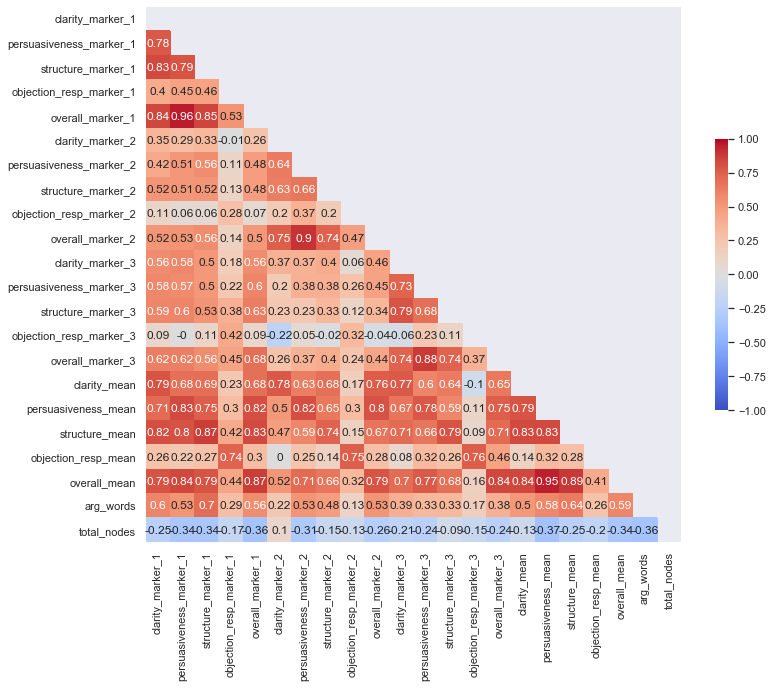

In [99]:
interest_cols = 'arg_words total_nodes'.split()
corr = df[score_cols + interest_cols].corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(round(corr, 2), cmap="coolwarm", square=True, ax=ax, cbar_kws={"shrink": .5}, 
            mask=mask, annot=True, vmin=-1, vmax=1)

In [110]:
def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

pvalues = calculate_pvalues(df[score_cols + interest_cols])

for col in list(pvalues):
    pvalues[col] = pvalues[col] >= 0.05

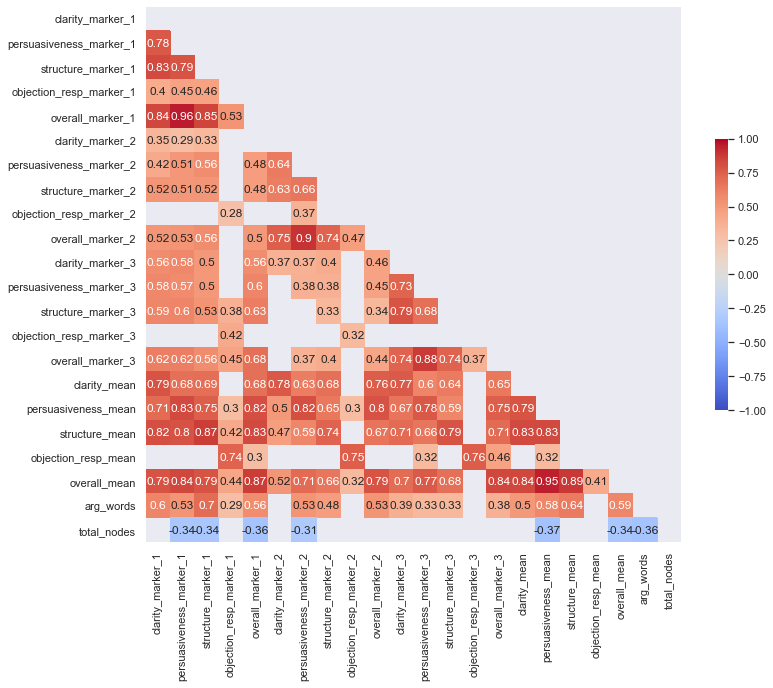

In [111]:
df_corr = df[score_cols + interest_cols].corr()
df_corr_only_significant = df_corr.where(pvalues, 'Insig')

f, ax = plt.subplots(figsize=(12, 10))
mask = pvalues | np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(round(corr, 2), cmap="coolwarm", square=True, ax=ax, cbar_kws={"shrink": .5}, 
            mask=mask, annot=True, vmin=-1, vmax=1)

In [5]:
df['arg_words'].mean()

248.22916666666666

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

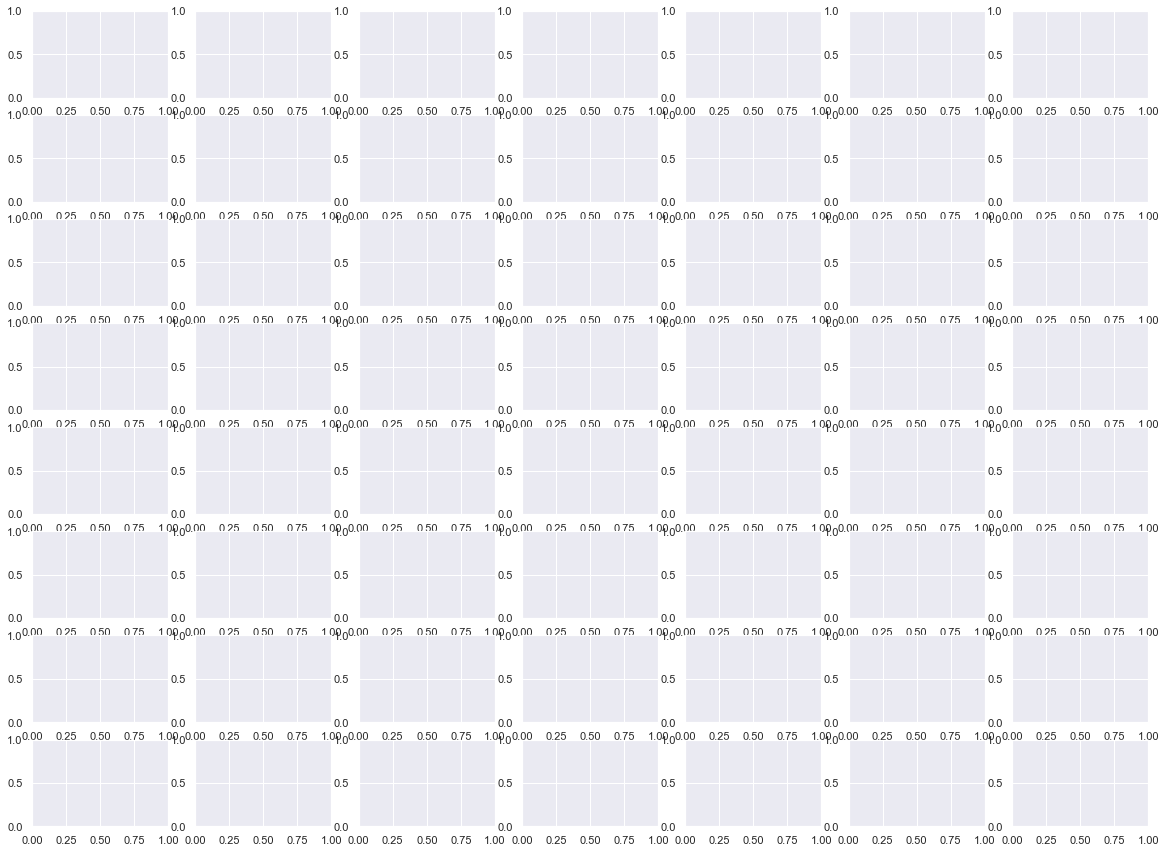

In [41]:
df.hist(figsize=[20, 15])

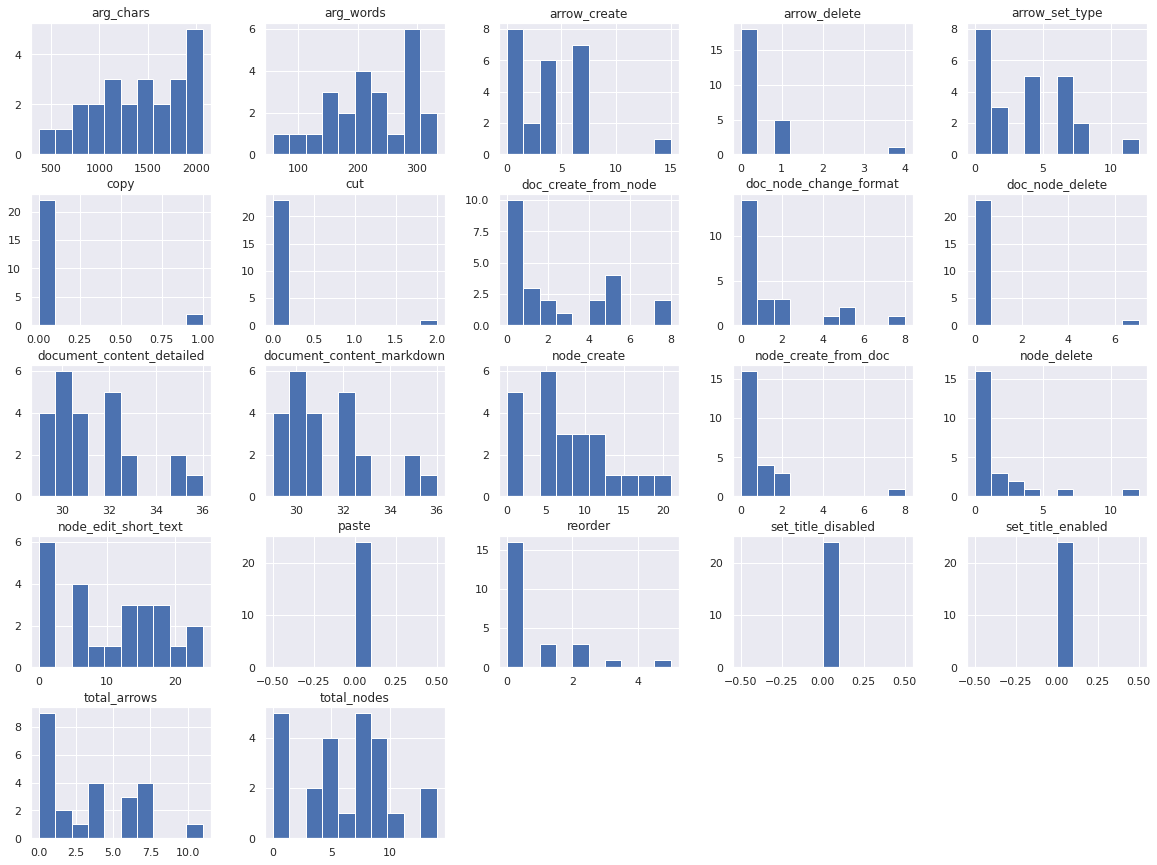

In [13]:
df_graph.hist(figsize=[20, 15]);

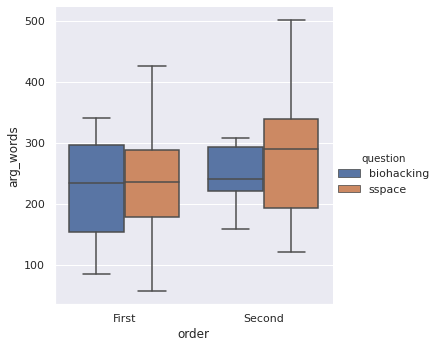

In [77]:
sns.catplot(data=df, x="order", y="arg_words", hue="question", kind="box")

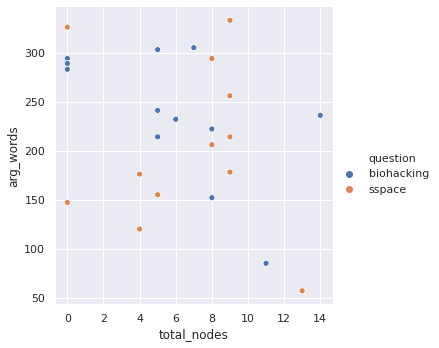

In [16]:
sns.relplot(data=df_graph, x='total_nodes', y='arg_words', hue='question')

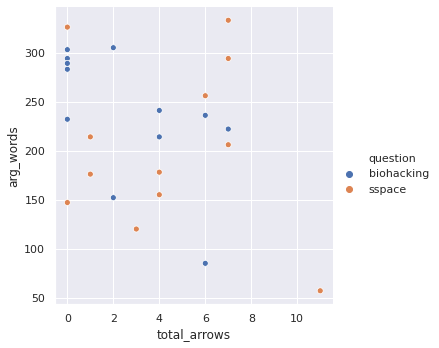

In [17]:
sns.relplot(data=df_graph, x='total_arrows', y='arg_words', hue='question')

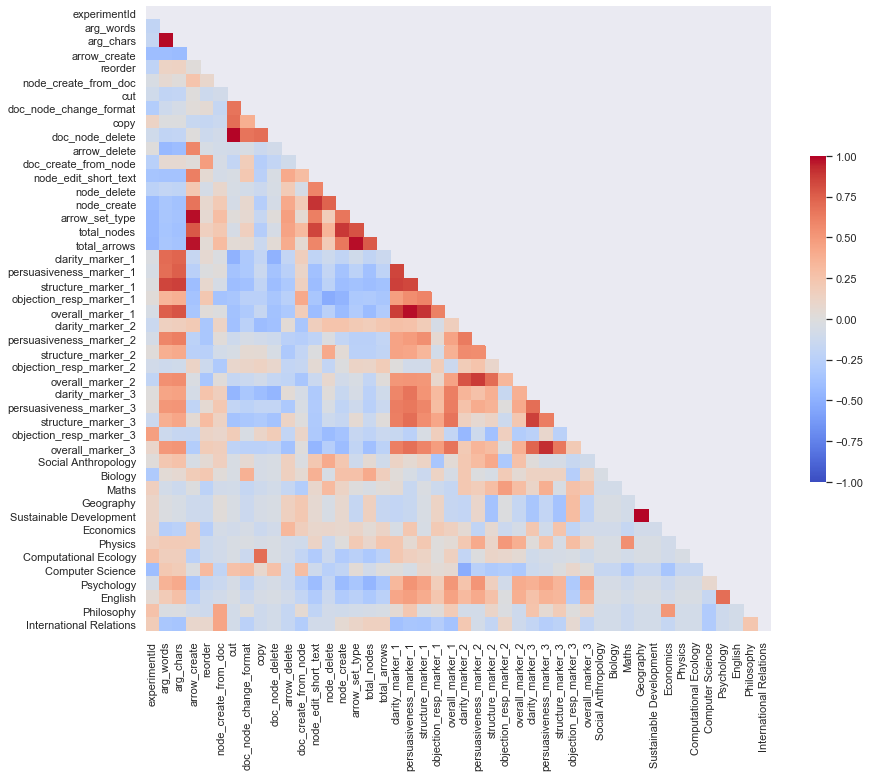

In [19]:
corr = df_graph.drop('set_title_enabled set_title_disabled document_content_markdown document_content_detailed paste'.split(), axis=1).corr()
f, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(round(corr, 2), cmap="coolwarm", square=True, ax=ax, cbar_kws={"shrink": .5}, 
            mask=mask, vmin=-1, vmax=1)

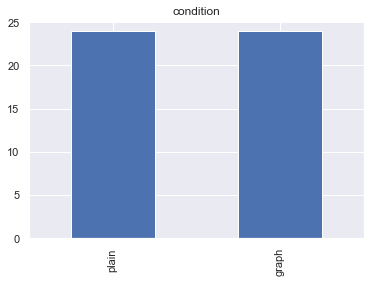

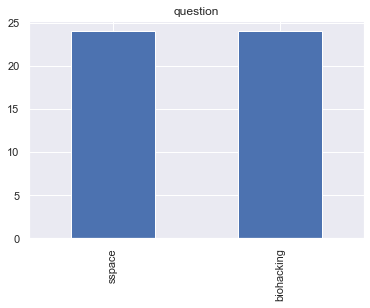

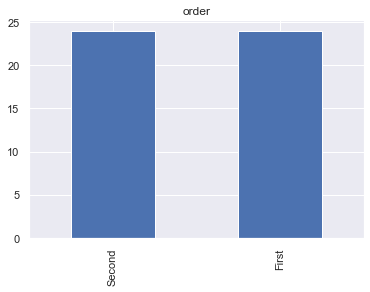

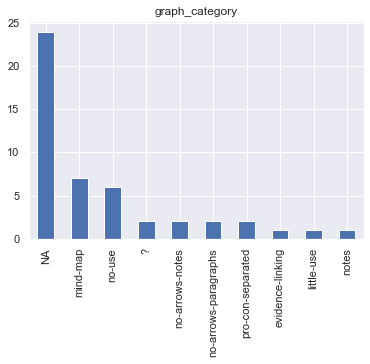

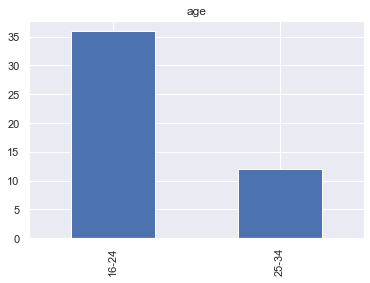

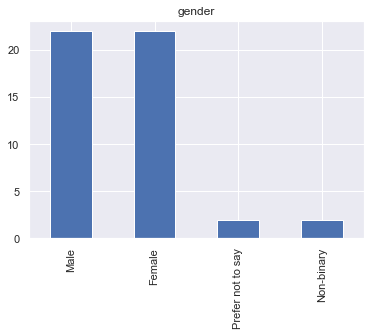

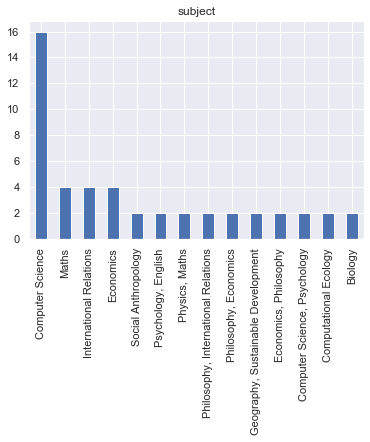

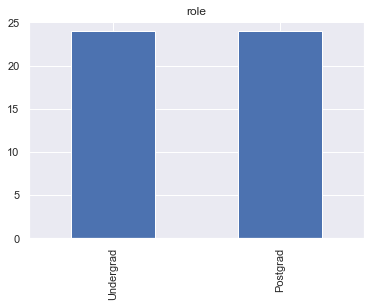

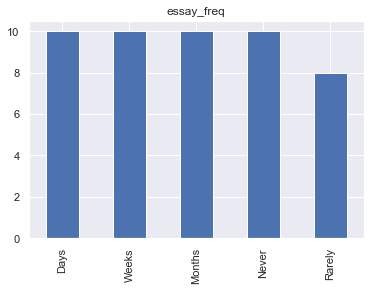

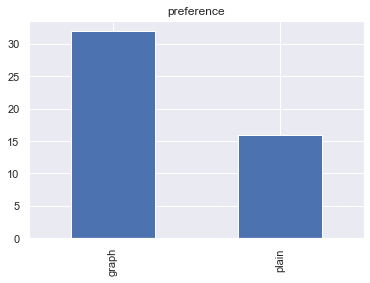

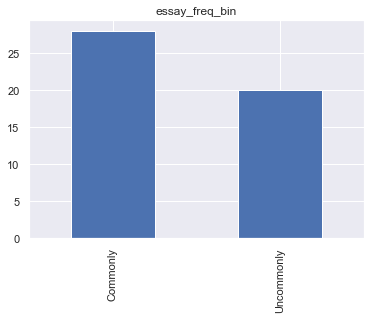

In [8]:
for col in df.select_dtypes(include='category'):
    df[col].value_counts().plot(kind='bar', title=col)
    plt.show()

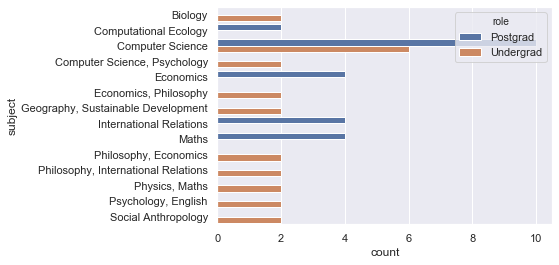

In [14]:
sns.countplot(data=df, y='subject', hue='role')

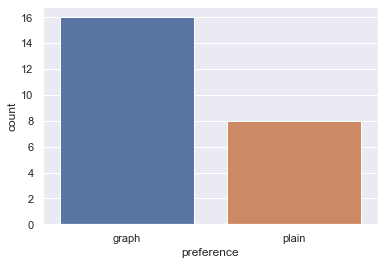

In [28]:
sns.countplot(data=df_graph, x="preference")

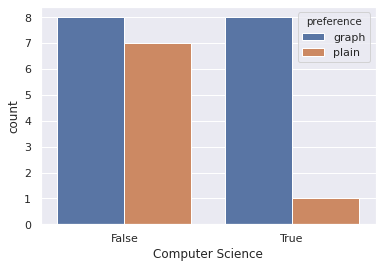

In [105]:
sns.countplot(data=df_graph, x="Computer Science", hue="preference")

In [31]:
df_graph['Computer Science'].value_counts()

False    15
True      9
Name: Computer Science, dtype: int64

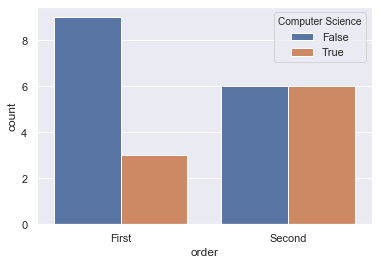

In [30]:
sns.countplot(data=df_graph, x="order", hue="Computer Science")

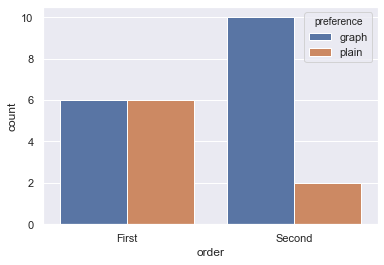

In [18]:
sns.countplot(data=df_graph, x="order", hue="preference")

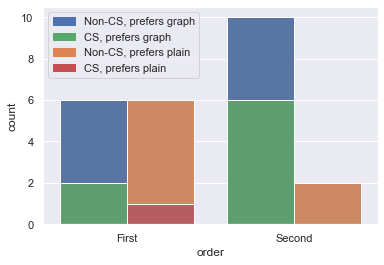

In [57]:
g = sns.countplot(data=df_graph, x="order", hue="preference")
sns.countplot(data=df_graph[df_graph["Computer Science"]], x="order", hue="preference", palette=sns.color_palette()[2:])


labels = [
    'Non-CS, prefers graph',
    'Non-CS, prefers plain',
    'CS, prefers graph',
    'CS, prefers plain'
]
patches = [mpatches.Patch(color=sns.color_palette()[i], label=labels[i]) for i in [0, 2, 1, 3]]
g.legend_ = plt.legend(handles=patches)

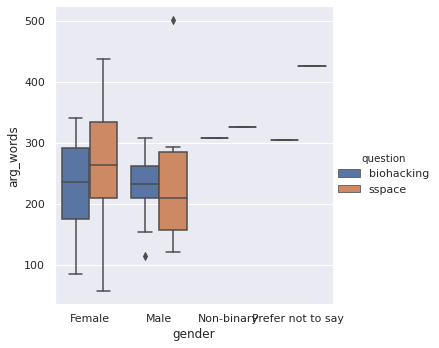

In [63]:
sns.catplot(data=df, x="gender", y="arg_words", hue="question", kind="box")

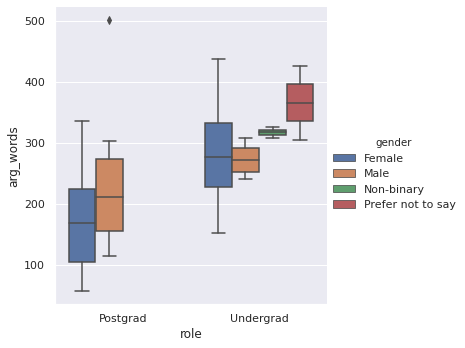

In [28]:
sns.catplot(data=df, x="role", y="arg_words", hue="gender", kind="box")

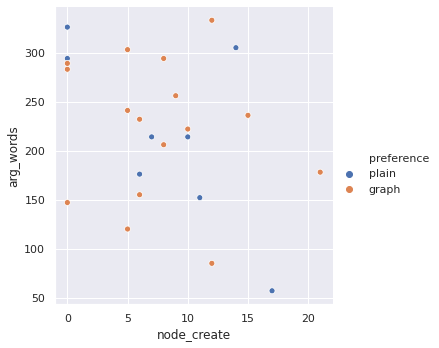

In [76]:
sns.relplot(data=df_graph, x="node_create", y="arg_words", hue="preference")

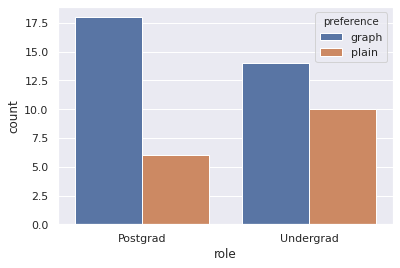

In [85]:
sns.countplot(x="role", hue="preference", data=df)

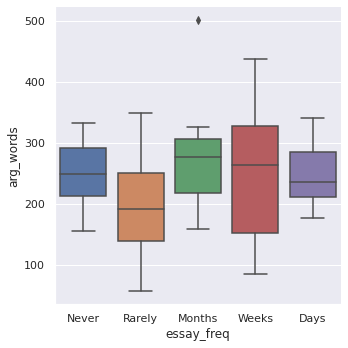

In [110]:
sns.catplot(data=df, x="essay_freq", y="arg_words", kind="box")

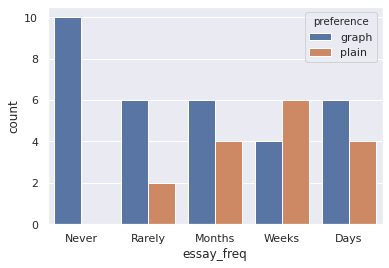

In [111]:
sns.countplot(x="essay_freq", hue="preference", data=df)

In [9]:
# Hypothesis: clarity, persuasiveness, structure, overall strength of argument will
# be higher on average for write-reason
# NOT confirmed - opposite is shown for persuasiveness and overall

for score in SCORE_TYPES:
    print_means(f'{score}_mean')
    
    run_ttest(df_plain, df_graph, f'{score}_mean')

Mean clarity_mean: plain 6.097, graph 5.792, diff 0.305
t(23)=0.979, p=0.338

Mean persuasiveness_mean: plain 5.306, graph 4.403, diff 0.903
t(23)=2.338, p=0.028

Mean structure_mean: plain 5.764, graph 5.458, diff 0.306
t(23)=0.927, p=0.364

Mean objection_resp_mean: plain 4.292, graph 3.778, diff 0.514
t(23)=1.231, p=0.231

Mean overall_mean: plain 5.264, graph 4.667, diff 0.597
t(23)=1.612, p=0.121



In [25]:
# Hypothesis: length will be greater for conventional text editor
# Confirmed

print_means('arg_words')
run_ttest(df_plain, df_graph, 'arg_words')

Mean arg_words: plain 274.875, graph 221.583, diff 53.292
t(23)=3.498, p=0.002



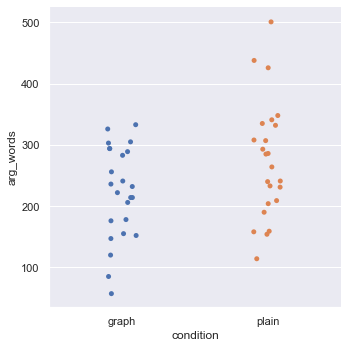

In [16]:
sns.catplot(data=df, x='condition', y='arg_words')

In [29]:
print(df_graph['gender'].value_counts())

Male                 11
Female               11
Prefer not to say     1
Non-binary            1
Name: gender, dtype: int64


In [38]:
# Hypothesis: graduate students will score higher on the marked measures above
# NOT confirmed - opposite is shown for all scores except obj_resp

for score in SCORE_TYPES:
    print_means(f'{score}_mean', df_a=df_postgrad, a_name='postgrad',
                df_b=df_undergrad, b_name="undergrad")
    run_ttest(df_postgrad, df_undergrad, f'{score}_mean', ttest=stats.ttest_ind)

Mean clarity_mean: postgrad 5.5, undergrad 6.389, diff -0.889
t(23)=-2.227, p=0.031

Mean persuasiveness_mean: postgrad 4.194, undergrad 5.514, diff -1.32
t(23)=-2.962, p=0.005

Mean structure_mean: postgrad 5.167, undergrad 6.056, diff -0.889
t(23)=-2.173, p=0.035

Mean objection_resp_mean: postgrad 3.972, undergrad 4.097, diff -0.125
t(23)=-0.28, p=0.781

Mean overall_mean: postgrad 4.375, undergrad 5.556, diff -1.181
t(23)=-2.864, p=0.006



Mean clarity_mean_plain_minus_graph: undergrad -0.362, postgrad 1.0, diff -1.362
t(22)=-3.418, p=0.001

Mean persuasiveness_mean_plain_minus_graph: undergrad 0.261, postgrad 1.556, diff -1.295
t(22)=-2.479, p=0.017

Mean structure_mean_plain_minus_graph: undergrad 0.058, postgrad 0.611, diff -0.553
t(22)=-1.193, p=0.239

Mean objection_resp_mean_plain_minus_graph: undergrad 0.638, postgrad 0.5, diff 0.138
t(22)=0.232, p=0.817

Mean overall_mean_plain_minus_graph: undergrad 0.087, postgrad 1.139, diff -1.052
t(22)=-2.067, p=0.045



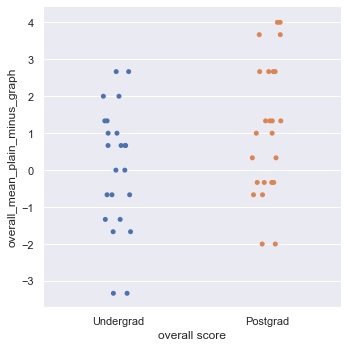

In [62]:
# Hypothesis: graduate students will show fewer differences between using one interface and the other

cols_to_grab = ['experimentId', 'role']
columns = cols_to_grab + [f'{score}_mean_plain_minus_graph' for score in SCORE_TYPES]
rows = []

skip = True
for experiment_id in df['experimentId']:
    if skip:
        skip = not skip
        continue
    
    both_conds = df[df['experimentId'] == experiment_id]
    row = [both_conds[col].iloc[0] for col in cols_to_grab]
    
    get_score = lambda cond: both_conds[both_conds['condition'] == cond][f'{score}_mean'].iloc[0]
    
    for score in SCORE_TYPES:
        row.append(get_score('plain') - get_score('graph'))
    
    rows.append(row)
    
df_diff = pd.DataFrame(np.array(rows), columns=columns)
for num_col in [f'{score}_mean_plain_minus_graph' for score in SCORE_TYPES]:
        df_diff[num_col] = pd.to_numeric(df_diff[num_col])

        
df_diff_ug = df_diff[df_diff['role'] == 'Undergrad']
df_diff_pg = df_diff[df_diff['role'] == 'Postgrad']

for score in SCORE_TYPES:
    sns.catplot(data=df_diff, x='role', y=f'{score}_mean_plain_minus_graph')
    print_means(f'{score}_mean_plain_minus_graph', df_a=df_diff_ug, a_name="undergrad",
                df_b=df_diff_pg, b_name="postgrad")
    run_ttest(df_diff_ug, df_diff_pg, f'{score}_mean_plain_minus_graph', ttest=stats.ttest_ind)

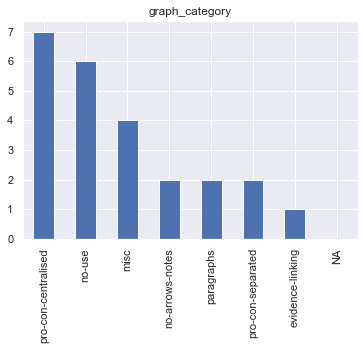

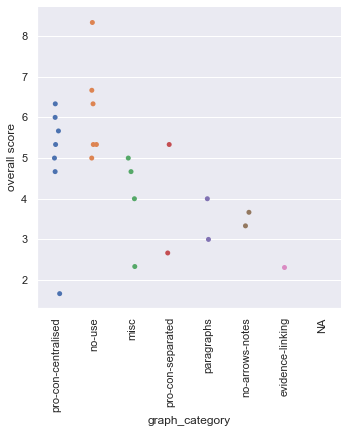

In [63]:
df_graph['graph_category'].value_counts().plot(kind='bar', title='graph_category')
for score in SCORE_TYPES:
    if score == 'overall':
        bar_plot = sns.catplot(data=df_graph, x='graph_category', y=f"{score}_mean")
        plt.setp(bar_plot.axes.flat[0].get_xticklabels(), rotation=90)
        bar_plot.set(ylabel='overall score')
    plt.show()    


Mean clarity_mean: sspace 5.972, biohacking 5.917, diff 0.055
Mean persuasiveness_mean: sspace 4.903, biohacking 4.806, diff 0.097
Mean structure_mean: sspace 5.458, biohacking 5.764, diff -0.306
Mean objection_resp_mean: sspace 4.042, biohacking 4.028, diff 0.014
Mean overall_mean: sspace 4.944, biohacking 4.986, diff -0.042


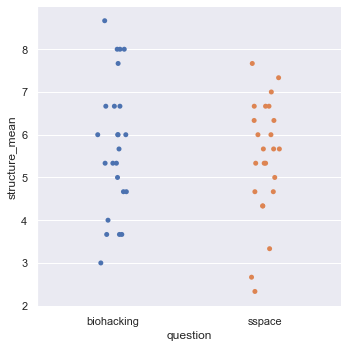

In [36]:
# analyse effect of question on scores 
for score in SCORE_TYPES:
    if score == 'structure':
        bar_plot = sns.catplot(data=df, x='question', y=f"{score}_mean")
    print_means(f'{score}_mean', df_a=df[df['question'] == 'sspace'], a_name="sspace",
                df_b=df[df['question'] == 'biohacking'], b_name="biohacking")
    plt.show()    


Mean clarity_mean: first 5.931, second 5.958, diff -0.027


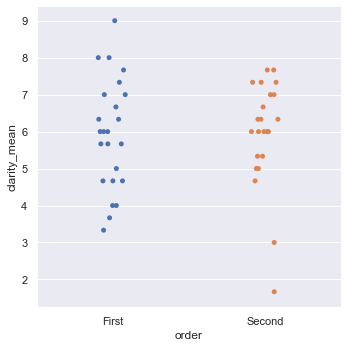

Mean persuasiveness_mean: first 4.653, second 5.056, diff -0.403


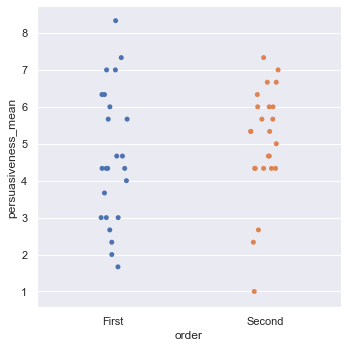

Mean structure_mean: first 5.611, second 5.611, diff 0.0


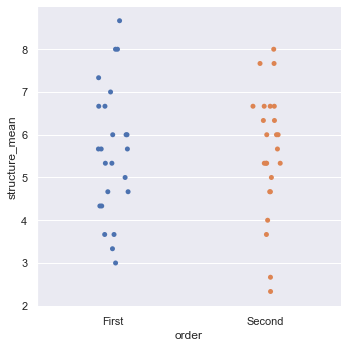

Mean objection_resp_mean: first 3.861, second 4.208, diff -0.347


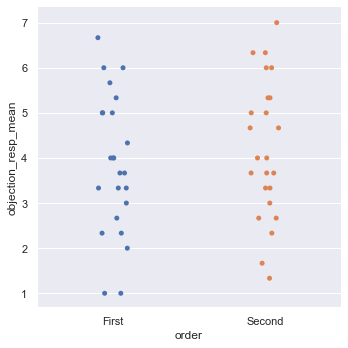

Mean overall_mean: first 4.764, second 5.167, diff -0.403


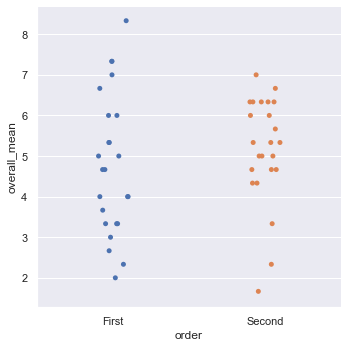

In [8]:
for score in SCORE_TYPES:
    bar_plot = sns.catplot(data=df, x='order', y=f"{score}_mean")
    print_means(f'{score}_mean', df_a=df[df['order'] == 'First'], a_name="first",
                df_b=df[df['order'] == 'Second'], b_name="second")
    plt.show()

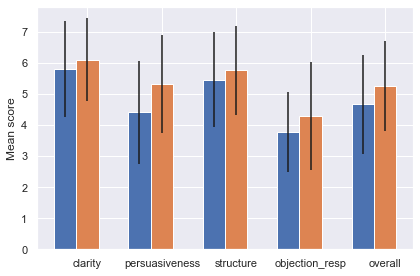

In [16]:

# plot mean scores by condition, with error bars
bar_width = 0.3

plot_scores = {}
for cond, cond_df in (('graph', df_graph), ('plain', df_plain)):
    plot_scores[cond] = {}
    plot_scores[cond]['mean'] = [cond_df[f'{score}_mean'].mean() for score in SCORE_TYPES]
    plot_scores[cond]['std'] = std_scores = [cond_df[f'{score}_mean'].std() for score in SCORE_TYPES]
    
graph_x = np.arange(len(SCORE_TYPES))
plain_x = [x + bar_width for x in graph_x]

fig, ax = plt.subplots()
ax.bar(graph_x, plot_scores['graph']['mean'], yerr=plot_scores['graph']['std'], width=bar_width)
ax.bar(plain_x, plot_scores['plain']['mean'], yerr=plot_scores['plain']['std'], width=bar_width)

ax.set_ylabel('Mean score')

# Add xticks on the middle of the group bars
plt.xticks([r + bar_width for r in range(len(SCORE_TYPES))], SCORE_TYPES)

# Save the figure and show
plt.tight_layout()
plt.show()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x04C7A710>,
      dtype=object)

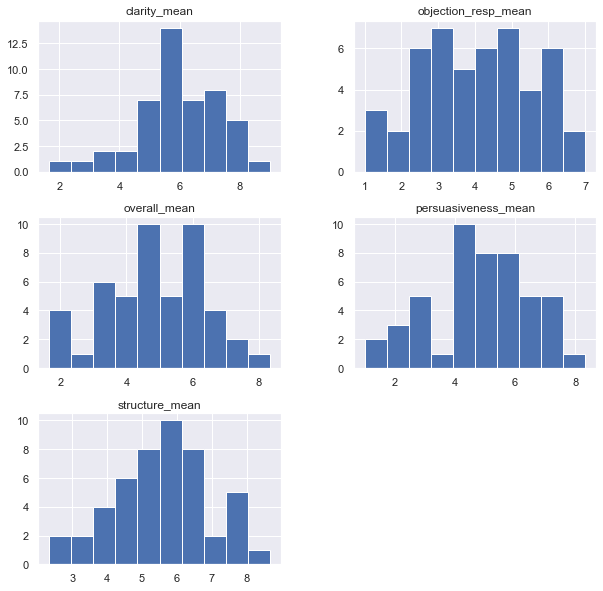

In [20]:
df[[f'{score}_mean' for score in SCORE_TYPES]].hist(figsize=[10, 10])

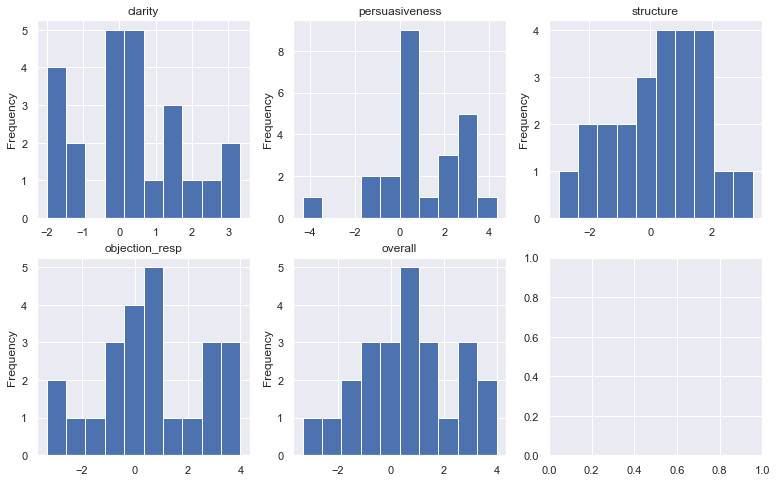

In [25]:
diffs = defaultdict(list)

def _get_score(df, score, exp_id):
    col = df[df['experimentId'] == exp_id]
    assert(len(col == 1))
    return col.iloc[0][f'{score}_mean']

for experiment_id in df['experimentId'].unique():
    for score in SCORE_TYPES:
        diffs[score].append(_get_score(df_plain, score, experiment_id) - _get_score(df_graph, score, experiment_id))
        
ax = plt.subplot(2,3,1)
ax.figure.set_figwidth(13)
ax.figure.set_figheight(8)
i = 1
for score_type, scores in diffs.items():
    series = pd.Series(scores)
    series.plot(kind='hist',title=score_type)
    i += 1
    plt.subplot(2, 3, i)
        
plt.show()

In [50]:
for score_type, scores in diffs.items():
    print(f'{score_type}: {stats.shapiro(scores)}')

clarity: (0.9618460536003113, 0.476624995470047)
persuasiveness: (0.9502502083778381, 0.27434584498405457)
structure: (0.9782961010932922, 0.8625018000602722)
objection_resp: (0.9613904356956482, 0.4669938087463379)
overall: (0.9853336811065674, 0.9706734418869019)


Mean clarity_mean: commonly 5.917, uncommonly 5.983, diff -0.066
t(27)=-0.157, p=0.876



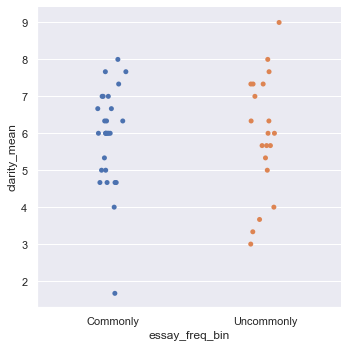

Mean persuasiveness_mean: commonly 4.905, uncommonly 4.783, diff 0.122
t(27)=0.246, p=0.806



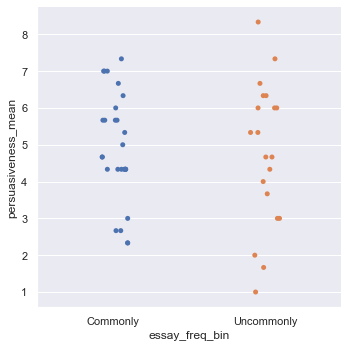

Mean structure_mean: commonly 5.667, uncommonly 5.533, diff 0.134
t(27)=0.306, p=0.761



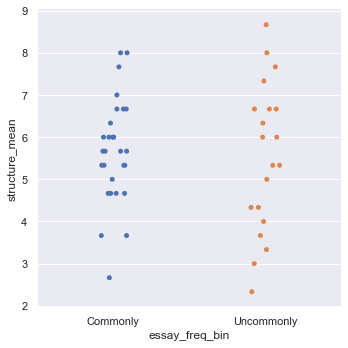

Mean objection_resp_mean: commonly 4.381, uncommonly 3.55, diff 0.831
t(27)=1.906, p=0.063



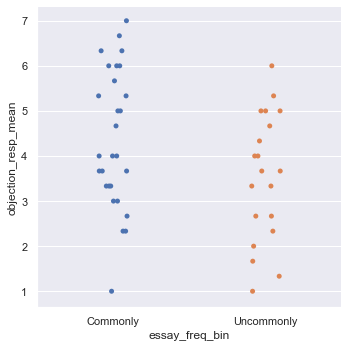

Mean overall_mean: commonly 5.083, uncommonly 4.8, diff 0.283
t(27)=0.627, p=0.534



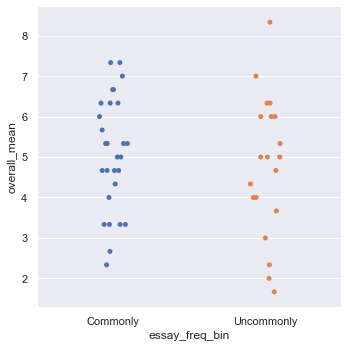


Bucket: commonly
Mean clarity_mean: plain 6.0, graph 5.833, diff 0.167
t(13)=0.365, p=0.721

Mean persuasiveness_mean: plain 5.262, graph 4.548, diff 0.714
t(13)=1.325, p=0.208

Mean structure_mean: plain 5.738, graph 5.595, diff 0.143
t(13)=0.309, p=0.762

Mean objection_resp_mean: plain 4.667, graph 4.095, diff 0.572
t(13)=0.896, p=0.387

Mean overall_mean: plain 5.31, graph 4.857, diff 0.453
t(13)=0.813, p=0.431


Bucket: uncommonly
Mean clarity_mean: plain 6.233, graph 5.733, diff 0.5
t(9)=1.218, p=0.254

Mean persuasiveness_mean: plain 5.367, graph 4.2, diff 1.167
t(9)=2.081, p=0.067

Mean structure_mean: plain 5.8, graph 5.267, diff 0.533
t(9)=1.124, p=0.29

Mean objection_resp_mean: plain 3.767, graph 3.333, diff 0.434
t(9)=0.876, p=0.404

Mean overall_mean: plain 5.2, graph 4.4, diff 0.8
t(9)=1.755, p=0.113



In [22]:
df_commonly = df[df['essay_freq_bin'] == 'Commonly']
df_uncommonly = df[df['essay_freq_bin'] == 'Uncommonly']

for score in SCORE_TYPES:
    bar_plot = sns.catplot(data=df, x='essay_freq_bin', y=f"{score}_mean")
    print_means(f'{score}_mean', df_a=df_commonly, a_name="commonly",
                df_b=df_uncommonly, b_name="uncommonly")
    run_ttest(df_commonly, df_uncommonly, f'{score}_mean', ttest=stats.ttest_ind)
    plt.show()

for df_name, df_bucketed in [("commonly", df_commonly), ("uncommonly", df_uncommonly)]:
    print(f'\nBucket: {df_name}')
    for score in SCORE_TYPES:
        df_bucketed_plain = df_bucketed[df_bucketed['condition'] == 'plain']
        df_bucketed_graph = df_bucketed[df_bucketed['condition'] == 'graph']
        print_means(f'{score}_mean', df_a=df_bucketed_plain, df_b=df_bucketed_graph)

        run_ttest(df_bucketed_plain, df_bucketed_graph, f'{score}_mean')